# E-commerce grew? How?

For which categories? For which consumers?

In [269]:
from datetime import date, datetime
import math
import os

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

# Additional / added columns
TOTAL_SPEND = 'spend' # unit price x quantity
YEAR = 'year'
YEAR_Q = 'year-Q'

MONTH = 'month'
QUARTER = 'quarter'
YYYY_MM = 'yyyy-mm'

IS_GIFT_CARD = 'gift card'

## Data preprocessing

### Data restrictions
Limit data to:
- purchases before 2022-11
- response ids that appear in both 2018 and 2022

#### Note: This means we are measuring growth WITHIN our sample
- additional growth can be attributed by growth in number of users

### Preprocess categories to make consistent category product assignments

We make a table mapping Product code (ASIN/ISBN) to product title, category

products_table:
```
ASIN/ISBN (Product Code), Category, Title, Purchasers
```
Some product IDs have multiple (different) titles and categories. We make this the canonical table. We use the title/category as the most commonly occuring in the dataset.

Purchasers is the number of distinct Response IDs that purchased the product.

Also: fixes some ISBNs that lost 0's in their prefix


## Read in Amazon data


In [304]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=['Order Date'])
# add date columns for analysis convenience
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
amzn_data[YYYY_MM] = amzn_data[DATE].apply(lambda d: date.strftime(d, '%Y-%m'))
amzn_data[MONTH] = amzn_data[DATE].apply(lambda d: d.month)
# quarters: map months to quarters as month 1-3: 1, 4-6: 2, 7-9: 3, 10-12: 4, 13-15: 5, etc
amzn_data[YEAR_Q] = amzn_data.apply(lambda row: '%s-Q%s' % (row[YEAR], math.ceil(row[MONTH]/3)), axis=1)
# add total spend
amzn_data[TOTAL_SPEND] = amzn_data.apply(lambda row: row[UNIT_PRICE]*row[QUANTITY], axis=1)
# peek at it:
amzn_data.head(3)

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,yyyy-mm,month,year-Q,spend
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,2018-12,12,2018-Q4,7.98
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,2018-12,12,2018-Q4,13.99
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF,2018,2018-12,12,2018-Q4,8.99


In [305]:
def print_amazon_data_metrics(df):
    print('%s purchases' % len(df))
    print('%s product codes' % df[PRODUCT_CODE].nunique())
    print('%s categories' % df[CATEGORY].nunique())
    print('%s response Ids' % df[RESPONSE_ID].nunique())
    
print_amazon_data_metrics(amzn_data)

1850717 purchases
939082 product codes
1871 categories
5027 response Ids


### Apply data restrictions

In [306]:
# Limit data to purchases before 2022-11
print('limiting data to purchases before 2022-11')
amzn_data = amzn_data[amzn_data[YYYY_MM] < '2022-11']
print_amazon_data_metrics(amzn_data)
amzn_data.sort_values(DATE, ascending=False).head(3)

limiting data to purchases before 2022-11
1737058 purchases
888301 product codes
1870 categories
5015 response Ids


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,year,yyyy-mm,month,year-Q,spend
1551128,2022-10-31,25.95,1.0,NY,Turmeric Gummies for Adults & Kids with Ginger...,B08VRTYWHK,HERBAL_SUPPLEMENT,R_R8FquFTs5uv64G5,2022,2022-10,10,2022-Q4,25.95
682338,2022-10-31,2.73,1.0,IL,Amazon Basics Fast Charging USB-C to USB-C2.0 ...,B085SBT6D8,ELECTRONIC_CABLE,R_2VsCpLMEP8xSuge,2022,2022-10,10,2022-Q4,2.73
194455,2022-10-31,9.39,1.0,OH,"[2+2 Pack] Galaxy S22 Screen Camera Protector,...",B0BGKCQQYT,SCREEN_PROTECTOR,R_1OIDizdfPJbwBnV,2022,2022-10,10,2022-Q4,9.39


In [307]:
# Limit data to response ids in both 2018 and 2022
print('Limiting data to user (response ids) consistently in 2018 and 2022')
rids2018 = amzn_data[amzn_data[YEAR]==2018][RESPONSE_ID].unique()
rids2022 = amzn_data[amzn_data[YEAR]==2022][RESPONSE_ID].unique()
rids = set(rids2018).intersection(set(rids2022))
amzn_data = amzn_data[amzn_data[RESPONSE_ID].isin(rids)]
print_amazon_data_metrics(amzn_data)

Limiting data to user (response ids) consistently in 2018 and 2022
1634832 purchases
845674 product codes
1845 categories
4152 response Ids


### Get the products table

In [308]:
# Warning: This is a slow operation
# I do this with groupby operations because it is much faster this way.

# products_table = amzn_data.groupby(
#     [PRODUCT_CODE]
# )[RESPONSE_ID].nunique().sort_values(ascending=False).rename('Purchasers').to_frame()
# product_cats = (
#     amzn_data.groupby([PRODUCT_CODE])[CATEGORY].apply(list)
#     .apply(lambda cats: pd.Series(cats).apply(str).apply(str.upper).mode()[0])
# )
# product_titles = amzn_data.groupby(
#     [PRODUCT_CODE]
# )[TITLE].apply(list).apply(lambda ts: pd.Series(ts).apply(str).mode()[0])
# products_table[CATEGORY] = products_table.index.map(product_cats)
# products_table[TITLE] = products_table.index.map(product_titles)

In [309]:
products_table_fpath = './preprocessed/products_table.csv'
products_table = pd.read_csv(products_table_fpath, index_col=0)
products_table.head()

,purchasers,Category,Title,FIXED ASIN/ISBN,MEN,WOMEN,GENDERED CATEGORY,RENAMED CATEGORY
ASIN/ISBN (Product Code),,,,,,,,
B00IX1I3G6,1157,GIFT_CARD,Amazon.com Gift Card Balance Reload,B00IX1I3G6,False,False,GIFT_CARD,GIFT_CARD
B086KKT3RX,875,ABIS_GIFT_CARD,Amazon Reload,B086KKT3RX,False,False,ABIS_GIFT_CARD,ABIS_GIFT_CARD
B07PCMWTSG,543,GIFT_CARD,Amazon.com eGift Card,B07PCMWTSG,False,False,GIFT_CARD,GIFT_CARD
B004LLIKVU,467,GIFT_CARD,Amazon.com eGift Card,B004LLIKVU,False,False,GIFT_CARD,GIFT_CARD
B07FZ8S74R,377,DIGITAL_DEVICE_3,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,False,False,DIGITAL_DEVICE_3,DIGITAL_DEVICE_3


#### Handle gift cards

There are multiple category names for gift cards.

Group the gift cards by reassigning their category to GIFT_CARD

In [310]:
def is_gift_code(row):
    cat = str(row['Category'])
    if cat in ['GIFT_CARD']:
        return True
    title = str(row['Title']).lower()
    if ('gift code' in title) or ('gift card' in title) or ('digital code' in title):
        return True
    if ('amazon reload' in title):
        return True
    return False

amzn_data[IS_GIFT_CARD] = amzn_data.apply(is_gift_code, axis=1)
gc_data = amzn_data[amzn_data[IS_GIFT_CARD]]
gc_pcodes = gc_data[PRODUCT_CODE].unique()
print('%s gift card purchases from %s users with %s different product codes and %s distinct categories' % 
      (len(gc_data), gc_data[RESPONSE_ID].nunique(), len(gc_pcodes), gc_data[CATEGORY].nunique()))
# gc_data.head(3)

37336 gift card purchases from 2787 users with 2005 different product codes and 68 distinct categories


In [311]:
pcodes_to_cats = {
    **products_table[CATEGORY].to_dict(), 
    **{pcode: 'GIFT_CARD' for pcode in gc_pcodes}
}

### Apply the data fixups

In [312]:
print('Updating product codes')
amzn_data[PRODUCT_CODE] = amzn_data[PRODUCT_CODE].map(products_table['FIXED ASIN/ISBN'])
print('Updating categories with updated product codes')
amzn_data[CATEGORY] = amzn_data[PRODUCT_CODE].map(pcodes_to_cats)
print_amazon_data_metrics(amzn_data)

Updating product codes
Updating categories with updated product codes
1634832 purchases
844626 product codes
1836 categories
4152 response Ids


## Categories comparison

Which categories grew the most? Which the least?

Measured by...
- number of distinct users making purchases
- total spend
- median per user spend 
    - actually doesn't work for category specific because not enough buyers when excluding Nov and December  --> end up with too many zeros

Later compare spend data to census retail sales data


Make tables for each metric with totals and percent change from 2018:

e.g.

purchasers:
```
category, 2018, 2019, 2020, 2021, 2022
```

purchasers_change: percent change from 2018
```
category, 2019, 2020, 2021, 2022
```



Limit analysis to categories with at least X distinct purchasers


TODO: How to handle that 2022 data is only up to October?
- a. limit all data to months 1-10



First just inspect categories of interest:
- Books
- footwear
- groceries

- also include overall expenditure changes

Make the yearly purchasers table -- exclude months 11 and 12 for consistency for 2022

In [313]:
years = [2018, 2019, 2020, 2021, 2022]

In [314]:
def get_purchasers(df, categories, year, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            .groupby(CATEGORY)[RESPONSE_ID].nunique()
            .reindex(categories)).fillna(0).apply(int)

In [315]:
book_cats = ['BOOK']
shoes_cats = ['SHOES', 'TECHNICAL_SPORT_SHOE', 'BOOT', 'SANDAL', 'SLIPPER']
grocery_cats = ['GROCERY', 'FOOD', 'VEGETABLE', 'FRUIT', 'DAIRY_BASED_CHEESE', 'BREAD', 'POULTRY', 'DRINK_FLAVORED', 'SNACK_CHIP_AND_CRISP', 'HERB', 'MEAT', 'FRUIT_SNACK', 'SAUCE', 'NUT_AND_SEED', 'SNACK_MIX', 'WATER', 'DAIRY_BASED_CREAM', 'NOODLE', 'PUFFED_SNACK', 'PACKAGED_SOUP_AND_STEW', 'MILK_SUBSTITUTE', 'CRACKER', 'COOKIE', 'SUGAR_CANDY', 'SYRUP', 'DAIRY_BASED_BUTTER', 'BREAKFAST_CEREAL', 'COFFEE', 'TEA', 'SNACK_FOOD_BAR', 'POPCORN', 'LEAVENING_AGENT', 'Grocery', 'DAIRY_BASED_YOGURT', 'CHOCOLATE_CANDY', 'EDIBLE_OIL_VEGETABLE', 'JUICE_AND_JUICE_DRINK', 'SEASONING', 'CAKE', 'DAIRY_BASED_ICE_CREAM', 'DAIRY_BASED_DRINK', 'CONDIMENT', 'LEGUME', 'RICE_MIX', 'CHEWING_GUM', 'FISH', 'CULINARY_SALT', 'SUGAR', 'NUTRITIONAL_SUPPLEMENT', 'NUT_BUTTER', 'PASTRY', 'THICKENING_AGENT', 'CEREAL', 'BAKING_MIX', 'SALAD_DRESSING', 'HERBAL_SUPPLEMENT']

In [316]:
def get_purchasers_yr_cats(df, cats, year, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[df[CATEGORY].isin(cats) & (df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            [RESPONSE_ID].nunique())

purchasers0 = pd.DataFrame(
    {yr: [get_purchasers_yr_cats(amzn_data, cats, yr) for cats in [book_cats, shoes_cats, grocery_cats]] for yr in years},
index = ['Books', 'Footwear', 'Grocery'])
purchasers0

,2018,2019,2020,2021,2022
Books,2144,2101,2315,2329,2220
Footwear,986,1170,1325,1518,1592
Grocery,1796,2016,2518,2716,2751


In [317]:
def get_change_from_2018_df(df):
    return pd.DataFrame({
        2019: (df[2019] - df[2018])/df[2018],
        2020: (df[2020] - df[2018])/df[2018],
        2021: (df[2021] - df[2018])/df[2018],
        2022: (df[2022] - df[2018])/df[2018],
    })

In [318]:
purchasers0_change = get_change_from_2018_df(purchasers0)
purchasers0_change

,2019,2020,2021,2022
Books,-0.020056,0.079757,0.086287,0.035448
Footwear,0.186613,0.343813,0.539554,0.614604
Grocery,0.122494,0.402004,0.512249,0.531737


In [319]:
# Calculate total spend
def get_total_spend_yr_cats(df, cats, year, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[df[CATEGORY].isin(cats) & (df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            [TOTAL_SPEND].sum())

total_spend0 = pd.DataFrame(
    {yr: [get_total_spend_yr_cats(amzn_data, cats, yr) for cats in [book_cats, shoes_cats, grocery_cats]] for yr in years},
index = ['Books', 'Footwear', 'Grocery'])
total_spend0

,2018,2019,2020,2021,2022
Books,195142.23,187602.87,204784.37,207365.29,183581.44
Footwear,98336.97,117570.83,123753.14,168636.64,191087.05
Grocery,212625.78,255198.86,483827.92,578276.32,630230.05


In [320]:
total_spend0_change = get_change_from_2018_df(total_spend0)
total_spend0_change

,2019,2020,2021,2022
Books,-0.038635,0.049411,0.062637,-0.059243
Footwear,0.195591,0.258460,0.714885,0.943186
Grocery,0.200225,1.275490,1.719691,1.964034


In [321]:
# calculate per user median spend -- cannot do category specific becase not enough users

def get_med_user_spend(df, year, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==year) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[TOTAL_SPEND].sum().reindex(rids).median())

pd.DataFrame(
    {'Median per user total spend': [get_med_user_spend(amzn_data, yr) for yr in years]},
index=years)

,Median per user total spend
2018,569.70
2019,687.34
2020,1050.95
2021,1314.17
2022,1209.14


Plots

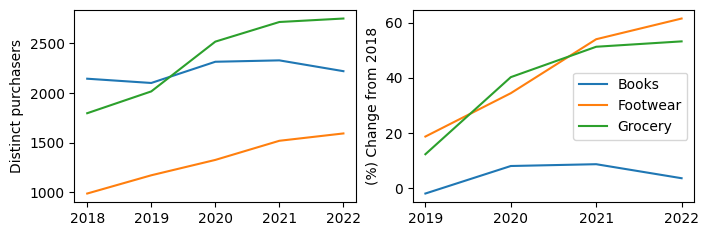

In [322]:
# Plot total and percent change in purchasers
fig, (ax_tot, ax_chg) = plt.subplots(1,2, figsize=(8, 2.5))
for cat in ['Books','Footwear','Grocery']:
    ax_tot.plot(purchasers0.transpose()[cat], label=cat)
    ax_chg.plot(100*purchasers0_change.transpose()[cat], label=cat)
ax_tot.set_ylabel('Distinct purchasers')
ax_chg.set_ylabel('(%) Change from 2018')
_ = ax_chg.legend() 
# display(purchasers0.transpose())
# display(purchasers0_change.transpose())

,Books,Footwear,Grocery
2018,195142.23,98336.97,212625.78
2019,187602.87,117570.83,255198.86
2020,204784.37,123753.14,483827.92
2021,207365.29,168636.64,578276.32
2022,183581.44,191087.05,630230.05


,Books,Footwear,Grocery
2019,-0.038635,0.195591,0.200225
2020,0.049411,0.258460,1.275490
2021,0.062637,0.714885,1.719691
2022,-0.059243,0.943186,1.964034


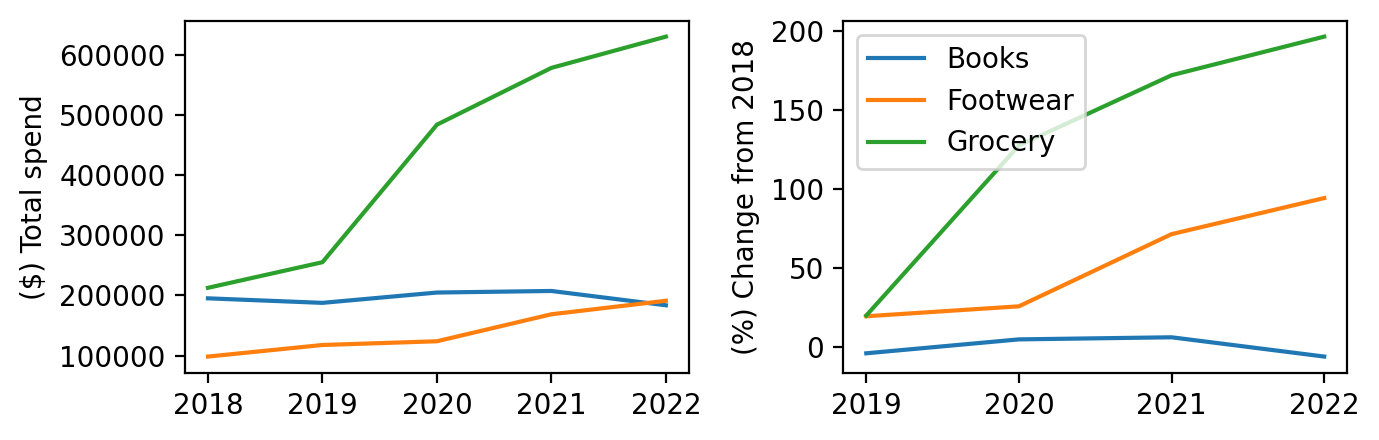

In [323]:
# Plot total and percent change in total spend
fig, (ax_tot, ax_chg) = plt.subplots(1,2, figsize=(7, 2.3), dpi=200)
for cat in ['Books','Footwear','Grocery']:
    ax_tot.plot(total_spend0.transpose()[cat], label=cat)
    ax_chg.plot(100*total_spend0_change.transpose()[cat], label=cat)
ax_tot.set_ylabel('($) Total spend')
ax_chg.set_ylabel('(%) Change from 2018')
ax_chg.set_xticks([2019,2020,2021,2022])
_ = ax_chg.legend() 
plt.tight_layout()
display(total_spend0.transpose())
display(total_spend0_change.transpose())

In [324]:
print('TODO: compare this with census data')

TODO: compare this with census data


Interested in some per-user overall metrics, taking median
- total spend
- distinct number of categories purchased from
- number of days making purchases

In [325]:
def get_med_per_user_total_spend(df, yr, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==yr) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[TOTAL_SPEND].sum().median())
    
def get_med_per_user_distinct_cats(df, yr, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==yr) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[CATEGORY].nunique().median())
    
def get_med_per_user_purchase_days(df, yr, exclude_nov_dec=True):
    exclude_months = [11,12] if exclude_nov_dec else []
    return (df[(df[YEAR]==yr) & (~df[MONTH].isin(exclude_months))]
            .groupby(RESPONSE_ID)[DATE].nunique().median())

In [326]:
agg_med_user_metrics = pd.DataFrame({
    'Total user spend': [get_med_per_user_total_spend(amzn_data, yr) for yr in years],
    'Purchase categories': [get_med_per_user_distinct_cats(amzn_data, yr) for yr in years],
    'Puchase days': [get_med_per_user_purchase_days(amzn_data, yr) for yr in years],
}, index=years)
agg_med_user_metrics

,Total user spend,Purchase categories,Puchase days
2018,569.70,16.0,13.0
2019,687.34,20.0,16.0
2020,1050.95,30.0,23.0
2021,1314.17,34.0,27.0
2022,1209.14,33.0,26.0


In [327]:
agg_med_user_metrics_chg = get_change_from_2018_df(agg_med_user_metrics.transpose()).transpose()
agg_med_user_metrics_chg

,Total user spend,Purchase categories,Puchase days
2019,0.206495,0.2500,0.230769
2020,0.844743,0.8750,0.769231
2021,1.306775,1.1250,1.076923
2022,1.122415,1.0625,1.000000


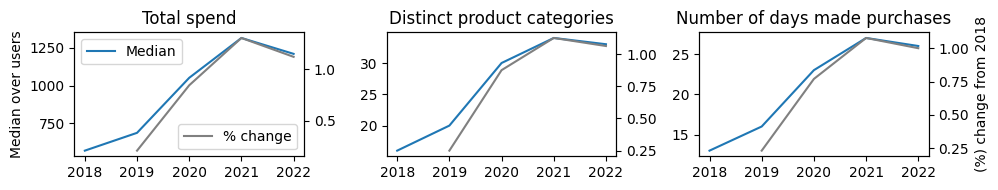

In [328]:
# Make a plot for each metric, showing total and pct change
fig, axes = plt.subplots(1,3,figsize=(10,2))
for i, metric in enumerate(agg_med_user_metrics.columns):
    ax = axes[i]
    ax.plot(agg_med_user_metrics[metric], label='Median')
    ax2 = ax.twinx()
    ax2.plot(agg_med_user_metrics_chg[metric], label='% change', color='gray')
    if i==0: 
        ax.set_ylabel('Median over users')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')
    if i==2:
        ax2.set_ylabel('(%) change from 2018')
axes[0].set_title('Total spend')
axes[1].set_title('Distinct product categories')
axes[2].set_title('Number of days made purchases')
    
plt.tight_layout()

### Broader set of categories

In [329]:
cats_p_threshold = 500 # at least this many purchasers
cats_purchasers = amzn_data.groupby(CATEGORY)[RESPONSE_ID].nunique().sort_values(ascending=False)
cats = cats_purchasers[cats_purchasers >= cats_p_threshold].index.tolist()
print('%s categories with at least %s purchasers' % (
len(cats), cats_p_threshold))
cats_purchasers.head(30)

382 categories with at least 500 purchasers


Category
NAN                                 4044
BOOK                                3657
ELECTRONIC_CABLE                    3099
CELLULAR_PHONE_CASE                 3023
SHIRT                               2916
HEADPHONES                          2871
HEALTH_PERSONAL_CARE                2868
GIFT_CARD                           2793
CHARGING_ADAPTER                    2488
SHOES                               2442
NUTRITIONAL_SUPPLEMENT              2421
PANTS                               2401
SOCKS                               2398
SKIN_MOISTURIZER                    2366
BATTERY                             2345
BEAUTY                              2327
HOME                                2276
SCREEN_PROTECTOR                    2222
CLEANING_AGENT                      2164
PORTABLE_ELECTRONIC_DEVICE_COVER    2161
TOYS_AND_GAMES                      2154
MEDICATION                          2153
DRINKING_CUP                        2152
WRITING_INSTRUMENT                  2108
SKIN_CL

In [330]:
purchasers_excl_nov_dec = pd.DataFrame(
    {yr: get_purchasers(amzn_data, cats, yr) for yr in years}
)
purchasers_excl_nov_dec

,2018,2019,2020,2021,2022
Category,,,,,
NAN,3055,3020,3194,3039,1899
BOOK,2144,2101,2315,2329,2220
ELECTRONIC_CABLE,1022,1196,1460,1598,1571
CELLULAR_PHONE_CASE,1003,1159,1224,1372,1447
SHIRT,905,1125,1269,1525,1537
...,...,...,...,...,...
DECORATIVE_SIGNAGE,41,47,93,133,171
CABLE_TIE,53,74,106,141,142
COMPUTER_COMPONENT,99,105,112,101,90


In [333]:
purchasers_chng2018 = get_change_from_2018_df(purchasers_excl_nov_dec)
purchasers_chng2018.sort_values(2022, ascending=False).head(15)

,2019,2020,2021,2022
Category,,,,
SAFETY_MASK,0.166667,57.583333,69.666667,40.000000
RESPIRATOR,0.200000,2.600000,15.666667,23.200000
DAIRY_BASED_CHEESE,1.000000,7.320000,8.480000,8.200000
MEAT,1.304348,8.739130,8.739130,7.869565
VEGETABLE,0.325581,5.348837,5.581395,5.790698
BREAD,0.151515,5.121212,5.727273,5.424242
ITEM_STAND,0.264706,2.147059,3.441176,5.205882
FRUIT,0.340426,4.893617,5.085106,4.978723
LEGUME,0.725000,4.450000,3.525000,3.925000


In [363]:
# inspect
def view_cat_titles(cat, num=5):
    print(cat)
    display(amzn_data[amzn_data[CATEGORY]==cat][TITLE].value_counts().to_frame().head(num))

In [364]:
cat = 'DIGITAL_DEVICE_4'
view_cat_titles(cat)

DIGITAL_DEVICE_4


,count
Title,
Fire TV Stick 4K streaming device with Alexa Voice Remote (includes TV controls) | Dolby Vision,443
"Fire TV Stick streaming device with Alexa built in, includes Alexa Voice Remote, HD, latest release",299
"Fire TV Stick Lite, free and live TV, Alexa Voice Remote Lite, smart home controls, HD streaming",112
"Fire TV Stick 4K, brilliant 4K streaming quality, TV and smart home controls, free and live TV",107
"Fire TV Stick with Alexa Voice Remote (includes TV controls), free & live TV without cable or satellite, HD streaming device",89


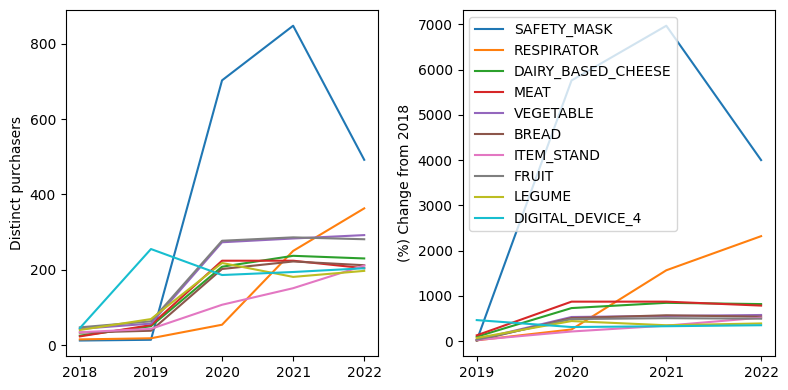

In [366]:
# Plot total and percent change in purchasers for top X
top_X = 10
fig, (ax_tot, ax_chg) = plt.subplots(1,2, figsize=(8, 4))
for cat in purchasers_chng2018.sort_values(2022, ascending=False).head(top_X).index:
    ax_tot.plot(purchasers_excl_nov_dec.transpose()[cat], label=cat)
    ax_chg.plot(100*purchasers_chng2018.transpose()[cat], label=cat)
ax_tot.set_ylabel('Distinct purchasers')
ax_chg.set_ylabel('(%) Change from 2018')
ax_chg.set_xticks([2019,2020,2021,2022])
ax_tot.set_xticks([2018,2019,2020,2021,2022])
_ = ax_chg.legend() 
plt.tight_layout()

Excluding safety mask and respirator


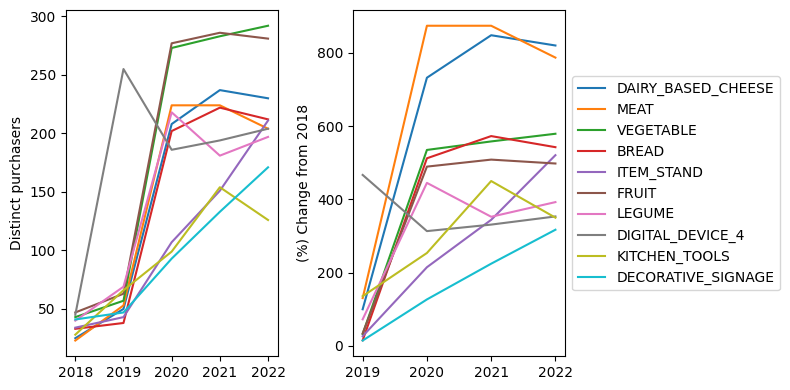

In [352]:
print('Excluding safety mask and respirator')
plt_df = purchasers_chng2018.drop(['SAFETY_MASK','RESPIRATOR']).sort_values(2022, ascending=False)

fig, (ax_tot, ax_chg) = plt.subplots(1,2, figsize=(8, 4))
for cat in plt_df.sort_values(2022, ascending=False).head(top_X).index:
    ax_tot.plot(purchasers_excl_nov_dec.transpose()[cat], label=cat)
    ax_chg.plot(100*purchasers_chng2018.transpose()[cat], label=cat)
ax_tot.set_ylabel('Distinct purchasers')
ax_chg.set_ylabel('(%) Change from 2018')
ax_chg.set_xticks([2019,2020,2021,2022])
ax_tot.set_xticks([2018,2019,2020,2021,2022])
_ = ax_chg.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt_df.head(15)

In [368]:
# view_cat_titles('DECORATIVE_SIGNAGE')

### Plotting and timeseries helpers

In [109]:
def get_plot_monthly_purchasers(purchases, ax=None, name=None):
    if ax is None: 
        fig,ax = plt.subplots(1,1, figsize=(10,1.5))
    monthly_ps = purchases.groupby(YYYY_MM)[RESPONSE_ID].nunique()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.plot(monthly_ps)
    _ = ax.set_xlim('2018-01', '2022-10')
    title = '%s: Distinct purchasers'%name if name else 'Distinct purchasers'
    ax.set_title(title)
    return ax, monthly_ps

def get_plot_yearly_purchasers(purchases, ax=None, name=None):
    if ax is None: 
        fig,ax = plt.subplots(1,1, figsize=(10,1.5))
    yearly_ps = purchases.groupby(YEAR)[RESPONSE_ID].nunique()
    ax.plot(yearly_ps)
    ax.set_xlim(2018, 2022)
    _ = ax.set_xticks([2018,2019,2020,2021,2022])
    title = '%s: Distinct purchasers'%name if name else 'Distinct purchasers'
    ax.set_title(title)
    return ax, yearly_ps


## Side quest in paper products and groceries

What are the paper products? What are their categories? Grocery?

Actually very few are categorized as GROCERY

In [110]:
# paper_towels 
def is_paper_towels_title(title):
    if 'paper towel' in str(title).lower(): return True
    return False

In [111]:
# way faster to do it this way then apply to the row
paper_towel_purchases = amzn_data[
    (amzn_data[TITLE].apply(is_paper_towels)) | (amzn_data[CATEGORY]=='PAPER_TOWEL')
]
print('paper towel purchases')
print('%s purchases' % len(paper_towel_purchases))
print('%s purchasers' % paper_towel_purchases[RESPONSE_ID].nunique())

paper towel purchases
2706 purchases
834 purchasers


In [112]:
paper_towel_purchases[CATEGORY].value_counts().head(10)

Category
PAPER_TOWEL             2186
PAPER_TOWEL_HOLDER       352
HEALTH_PERSONAL_CARE      96
KITCHEN                   10
STORAGE_RACK               9
TOILET_PAPER_HOLDER        8
TOWEL                      7
GROCERY                    6
TOILET_PAPER               4
DISPOSABLE_NAPKIN          4
Name: count, dtype: int64

In [113]:
# what about paper towel categorized products that do not have paper twel in the title?
weird_p_towels = amzn_data[
    (amzn_data[CATEGORY]=='PAPER_TOWEL') & (~amzn_data[TITLE].apply(is_paper_towels))
]
print(len(weird_p_towels))
weird_p_towels[TITLE].value_counts().to_frame().head()

207


,count
Title,
Bounty,85
Bamboo Towels - Heavy Duty Machine Washable Reusable Rayon Towels - One roll replaces 6 months of towels! 1 Pack,17
"Scott Shop Towels Original (75147), Blue, 55 Sheets/Standard Roll, 12 Rolls/Case, 660 Towels/Case",12
"Kleenex Expressions Disposable Paper Hand Towels, Paper Hand Towels for Bathroom, 6 Boxes, 60 Hand Towels per Box (360 Total Tissues)",12
Genuine Joe Multifold Towels,8


#### Results:

2020 (COVID) brought some new paper product buyers who then did not buy paper towels again in 2021, 2022

Results differ if we aggregate to yearly vs monthly distinct purchasers.


Interesting findings for both TP and paper towels:
- for both products there is a spike at the start of COVID and then a drop
    - spike likely due to perceived run on market
    - drop may be due to over-buying (lack of demand) or that there was a lack of supply (impact of run and supply chain issues)
    
- both had upward trends 2018 to 2019
- purchasing slope increased / accelerated in 2020 and PEAKED
- purchasing then went back down and *plateaued*
- i.e. there may be many users who purchased these products in 2020 and then did not purchase in 2021 and 2022


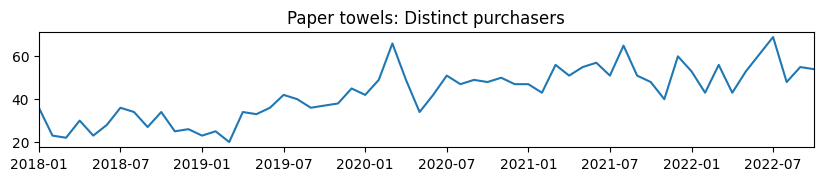

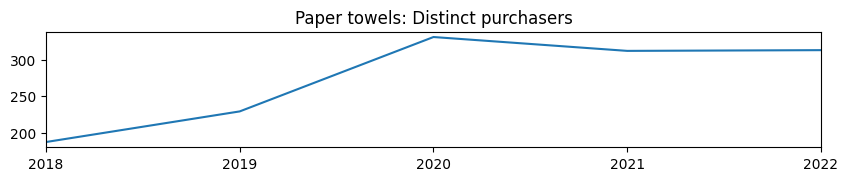

In [114]:
_ax, monthly_paper_towel_ps = get_plot_monthly_purchasers(paper_towel_purchases, name='Paper towels')
_ax, yearly_paper_towel_ps = get_plot_yearly_purchasers(paper_towel_purchases, name='Paper towels')

### Toilet paper

Maybe a bit more complicated due to the big COVID run on the TP markets

More total purchasers than for paper towels

In [61]:
def is_toilet_paper_title(title):
    if 'toilet paper' in str(title).lower(): return True
    return False

In [66]:
tp_purchases = amzn_data[amzn_data[TITLE].apply(is_toilet_paper_title)]
tp_purchases[CATEGORY].value_counts().head(10)

Category
TOILET_PAPER            4319
TOILET_PAPER_HOLDER      301
HEALTH_PERSONAL_CARE      96
TOWEL_HOLDER              18
SKIN_CLEANING_WIPE        13
PAPER_TOWEL_HOLDER        12
GROCERY                   11
SHELF                      9
DECORATIVE_SIGNAGE         7
CABINET                    7
Name: count, dtype: int64

In [70]:
# Avoid the toilet paper holders
tp_purchases = amzn_data[
    (amzn_data[TITLE].apply(is_toilet_paper_title)) & \
    (amzn_data[CATEGORY].apply(lambda c: '_HOLDER' not in c))
]
print('toilet paper purchases')
print('%s purchases' % len(tp_purchases))
print('%s purchasers' % tp_purchases[RESPONSE_ID].nunique())

toilet paper purchases
4550 purchases
962 purchasers


In [71]:
tp_purchases[CATEGORY].value_counts().head()

Category
TOILET_PAPER            4319
HEALTH_PERSONAL_CARE      96
SKIN_CLEANING_WIPE        13
GROCERY                   11
SHELF                      9
Name: count, dtype: int64

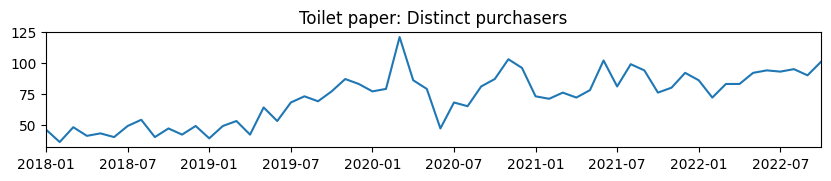

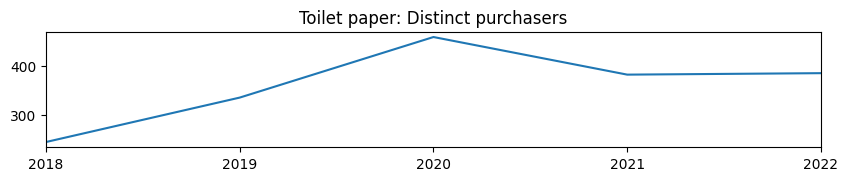

In [115]:
_ax, monthly_tp_ps = get_plot_monthly_purchasers(tp_purchases, name='Toilet paper')
_ax, yearly_tp_ps = get_plot_yearly_purchasers(tp_purchases, name='Toilet paper')

### The other side of grocery related products

The 'sensory' items

e.g. vegetables. How can our data support this?

In [121]:
fresh_groc_cats = [
    'VEGETABLE', 'FRUIT', 'DAIRY_BASED_CHEESE', 'POULTRY', 'FISH',
]
fresh_groc_purchases = amzn_data[amzn_data[CATEGORY].isin(fresh_groc_cats)]
fresh_groc_purchases[CATEGORY].value_counts()

Category
VEGETABLE             10639
FRUIT                  7503
DAIRY_BASED_CHEESE     4823
POULTRY                3259
FISH                   1706
Name: count, dtype: int64

In [117]:
# these all look like vegetables
vegetable_ps = (amzn_data[amzn_data[CATEGORY]=='VEGETABLE']
              .groupby(TITLE)[RESPONSE_ID].nunique().sort_values(ascending=False))
vegetable_ps.head(10)

Title
Yellow Onion                                             81
Cucumber Slicing                                         75
Red Onion                                                68
Green Bell Pepper                                        68
Fresh Brand – Cut and Peeled Baby Carrots, 16 oz         58
365 by Whole Foods Market, Broccoli Florets, 12 Ounce    57
Asparagus, 1 Bunch                                       52
Organic Garlic                                           52
Fresh Brand – Russet Potatoes, 5 lb                      50
365 by Whole Foods Market, Organic Baby Spinach, 5 oz    50
Name: Survey ResponseID, dtype: int64

In [122]:
# These all look like fresh items
(fresh_groc_purchases.groupby(TITLE)[RESPONSE_ID].nunique()
 .sort_values(ascending=False).head(20))

Title
Strawberries, 1 lb                                                        114
Dole Bananas, 2 lb Bag                                                     81
Yellow Onion                                                               81
Cucumber Slicing                                                           75
Bananas, One Bunch                                                         72
Green Bell Pepper                                                          68
Red Onion                                                                  68
Banana Conventional, 1 Each                                                67
Lemon                                                                      65
Blueberries, 1 Pint                                                        60
Fresh Brand – Cut and Peeled Baby Carrots, 16 oz                           58
365 by Whole Foods Market, Broccoli Florets, 12 Ounce                      57
Lime                                                      

In [123]:
# People ordered fresh items in many different states
(fresh_groc_purchases
 .groupby(STATE)[RESPONSE_ID].nunique()
 .sort_values(ascending=False).head(10))

Shipping Address State
CA    133
TX     82
FL     81
NY     75
PA     63
OH     55
IL     55
WA     45
NC     39
GA     37
Name: Survey ResponseID, dtype: int64

In [124]:
# How often are these fresh items labeled as GROCERY? Answer: Never! 
# Remember we were using consistent product codes in preprocessing
fresh_groc_pcodes = fresh_groc_purchases[PRODUCT_CODE].unique()
fresh_groc_purchases = amzn_data[amzn_data[PRODUCT_CODE].isin(fresh_groc_pcodes)]
fresh_groc_purchases[CATEGORY].value_counts().head(10)

Category
VEGETABLE             10639
FRUIT                  7503
DAIRY_BASED_CHEESE     4823
POULTRY                3259
FISH                   1706
Name: count, dtype: int64

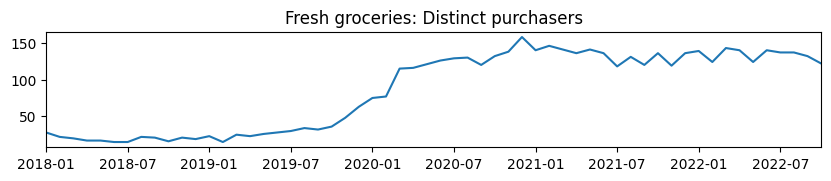

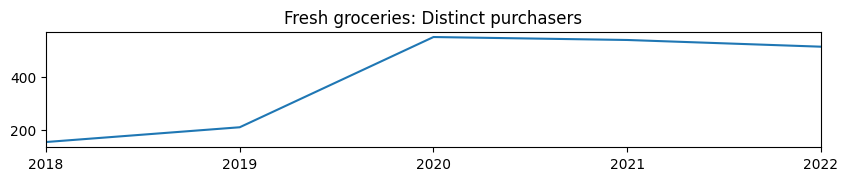

In [128]:
_ax, monthly_fresh_ps = get_plot_monthly_purchasers(fresh_groc_purchases, name='Fresh groceries')
_ax, yearly_fresh_ps = get_plot_yearly_purchasers(fresh_groc_purchases, name='Fresh groceries')